In [1]:
import numpy as np
import pandas as pd

import pmdarima as pm

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Модель для прогнозирования, например ARIMA
from sktime.forecasting.arima import ARIMA
# Визуализация временных рядов
from sktime.utils.plotting import plot_series
# Модули для кросс-валидации
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter, SlidingWindowSplitter, SingleWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError # Метрики MSE, MAE, MAPE
# Поиск оптимальных гиперпараметров по сетке
from sktime.forecasting.model_selection import ForecastingGridSearchCV
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [2]:
y = web.DataReader(name='DGS10', data_source='fred', start='2000-01')
y

,DGS10
DATE,
2000-01-03,6.58
2000-01-04,6.49
2000-01-05,6.62
2000-01-06,6.57
2000-01-07,6.52
...,...
2025-03-21,4.25
2025-03-24,4.34
2025-03-25,4.31


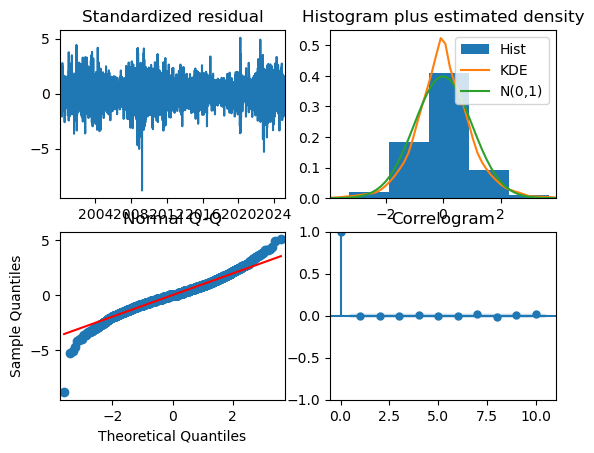

In [3]:
arima = pm.ARIMA(order=(2,0,2), trend='n')
arima.fit(y)
arima.summary()
arima.plot_diagnostics()
plt.show()

In [4]:
forecasts = arima.fit_predict(y, n_periods=10)
forecasts

2025-03-28    4.375885
2025-03-31    4.374190
2025-04-01    4.373416
2025-04-02    4.372414
2025-04-03    4.371468
2025-04-04    4.370509
2025-04-07    4.369553
2025-04-08    4.368597
2025-04-09    4.367641
2025-04-10    4.366685
Freq: B, dtype: float64

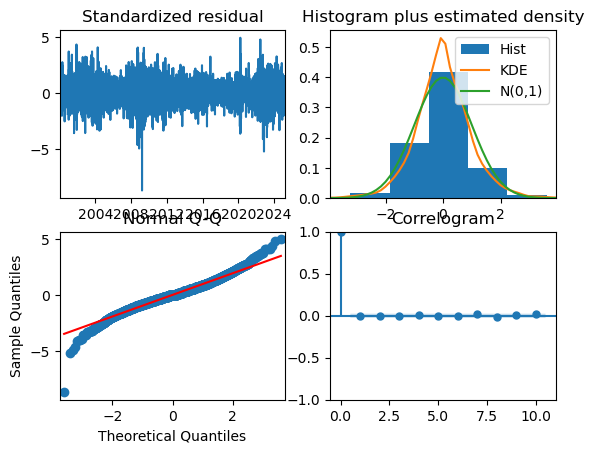

In [5]:
arima = pm.ARIMA(order=(2,0,2), trend='ct')
arima.fit(y)
arima.summary()
arima.plot_diagnostics()
plt.show()

In [6]:
forecasts = arima.fit_predict(y, n_periods=10)
forecasts

2025-03-28    4.375958
2025-03-31    4.373453
2025-04-01    4.372210
2025-04-02    4.370789
2025-04-03    4.369396
2025-04-04    4.368000
2025-04-07    4.366607
2025-04-08    4.365216
2025-04-09    4.363826
2025-04-10    4.362438
Freq: B, dtype: float64

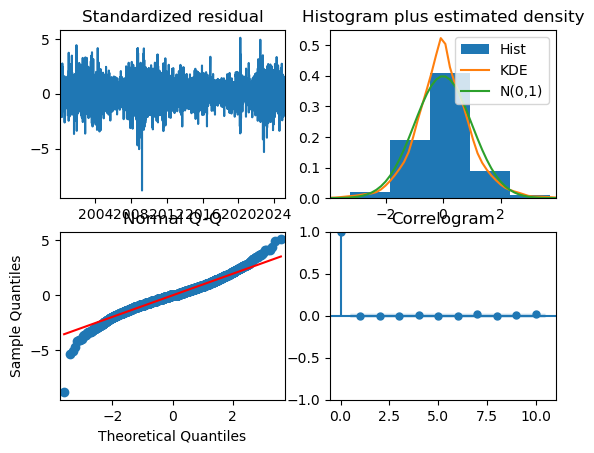

In [7]:
arima = pm.ARIMA(order=(2,1,0), trend='c')
arima.fit(y)
arima.summary()
arima.plot_diagnostics()
plt.show()

In [8]:
forecasts = arima.fit_predict(y, n_periods=10)
forecasts

2025-03-28    4.377185
2025-03-31    4.375180
2025-04-01    4.374989
2025-04-02    4.374740
2025-04-03    4.374390
2025-04-04    4.374044
2025-04-07    4.373704
2025-04-08    4.373363
2025-04-09    4.373022
2025-04-10    4.372681
Freq: B, dtype: float64

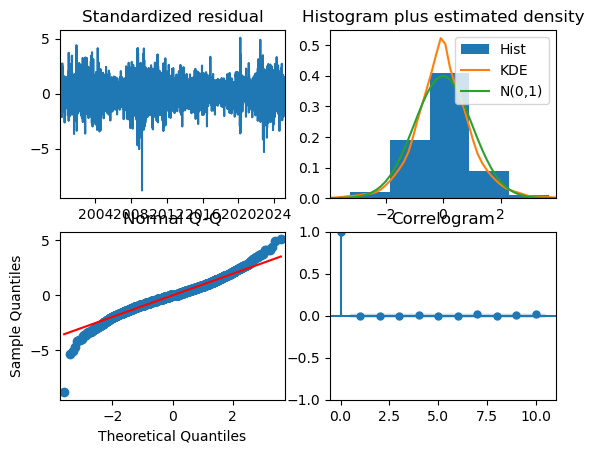

In [9]:
arima = pm.ARIMA(order=(2,1,1), trend='n')
arima.fit(y)
arima.summary()
arima.plot_diagnostics()
plt.show()

In [10]:
forecasts = arima.fit_predict(y, n_periods=10)
forecasts

2025-03-28    4.377504
2025-03-31    4.375905
2025-04-01    4.376098
2025-04-02    4.376182
2025-04-03    4.376168
2025-04-04    4.376164
2025-04-07    4.376165
2025-04-08    4.376165
2025-04-09    4.376165
2025-04-10    4.376165
Freq: B, dtype: float64

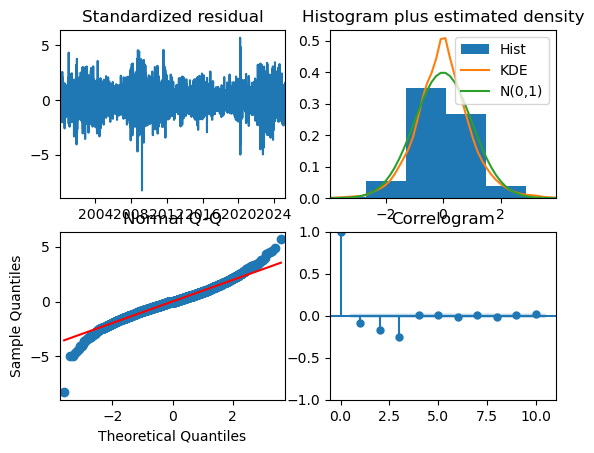

In [11]:
arima = pm.ARIMA(order=(2,2,0), trend='n')
arima.fit(y)
arima.summary()
arima.plot_diagnostics()
plt.show()

In [12]:
forecasts = arima.fit_predict(y, n_periods=10)
forecasts

2025-03-28    4.390488
2025-03-31    4.417429
2025-04-01    4.440890
2025-04-02    4.460502
2025-04-03    4.483921
2025-04-04    4.506287
2025-04-07    4.527925
2025-04-08    4.550429
2025-04-09    4.572639
2025-04-10    4.594718
Freq: B, dtype: float64

In [13]:
# Зададим список из специфицированных моделей прогнозирования
forecasters = [ARIMA(order=(2,0,2), trend='n'), ARIMA(order=(2,0,2), trend='ct'), ARIMA(order=(2,1,0), trend='c'), ARIMA(order=(2,1,1), trend='n'), ARIMA(order=(2,2,0), trend='n')]

# специфицируем метод кросс-валидации. Например, SlidingWindowSplitter
cv_strategy = SlidingWindowSplitter(fh=np.arange(1, 251), initial_window=5000, step_length=250)

# инициализируем метрики
metric = [MeanSquaredError(square_root=False), MeanAbsoluteError(), MeanAbsolutePercentageError()]

# датафрейм с метриками по столбцам
cv_data = pd.DataFrame(data=None, columns=['MSE', 'MAE', 'MAPE'])

for model in forecasters:
	print(model)
	cv_res = evaluate(forecaster=model, y=y, cv=cv_strategy, strategy="refit", return_data=False, scoring=metric)
	# print(df.iloc[:,:len(metric)].mean()) # метрики для каждой модели
	cv_data.loc[len(cv_data.index)] = cv_res.iloc[:,[0,1,2]].mean().values

# результаты кросс-валидации в виде датафрейма
cv_data

ARIMA(order=(2, 0, 2), trend='n')
ARIMA(order=(2, 0, 2), trend='ct')
ARIMA(order=(2, 1, 0), trend='c')
ARIMA(order=(2, 1, 1), trend='n')
ARIMA(order=(2, 2, 0), trend='n')


,MSE,MAE,MAPE
0,0.664048,0.664048,0.664048
1,2.651233,2.651233,2.651233
2,1.877705,1.877705,1.877705
3,0.876500,0.876500,0.876500
4,3.315043,3.315043,3.315043


In [14]:
# Индекс модели
for i in range(cv_data.shape[1]):
	print(f'{cv_data.columns[i]}: model #={cv_data.iloc[:,i].argmin()}')

MSE: model #=0
MAE: model #=0
MAPE: model #=0


In [15]:
# Зададим список из специфицированных моделей прогнозирования
forecasters = [ARIMA(order=(2,0,2), trend='n'), ARIMA(order=(2,0,2), trend='ct'), ARIMA(order=(2,1,0), trend='c'), ARIMA(order=(2,1,1), trend='n'), ARIMA(order=(2,2,0), trend='n')]

# специфицируем метод кросс-валидации. Например, SlidingWindowSplitter
cv_strategy = ExpandingWindowSplitter(fh=np.arange(1, 251), initial_window=5000, step_length=250)

# инициализируем метрики
metric = [MeanSquaredError(square_root=False), MeanAbsoluteError(), MeanAbsolutePercentageError()]

# датафрейм с метриками по столбцам
cv_data = pd.DataFrame(data=None, columns=['MSE', 'MAE', 'MAPE'])

for model in forecasters:
	print(model)
	cv_res = evaluate(forecaster=model, y=y, cv=cv_strategy, strategy="refit", return_data=False, scoring=metric)
	# print(df.iloc[:,:len(metric)].mean()) # метрики для каждой модели
	cv_data.loc[len(cv_data.index)] = cv_res.iloc[:,[0,1,2]].mean().values

# результаты кросс-валидации в виде датафрейма
cv_data

ARIMA(order=(2, 0, 2), trend='n')
ARIMA(order=(2, 0, 2), trend='ct')
ARIMA(order=(2, 1, 0), trend='c')
ARIMA(order=(2, 1, 1), trend='n')
ARIMA(order=(2, 2, 0), trend='n')


,MSE,MAE,MAPE
0,0.651499,0.651499,0.651499
1,0.698982,0.698982,0.698982
2,0.651928,0.651928,0.651928
3,0.640494,0.640494,0.640494
4,3.700145,3.700145,3.700145


In [16]:
# Индекс модели
for i in range(cv_data.shape[1]):
	print(f'{cv_data.columns[i]}: model #={cv_data.iloc[:,i].argmin()}')

MSE: model #=3
MAE: model #=3
MAPE: model #=3


In [17]:
# Зададим метод прогнозирования
forecaster = ARIMA()

# разбиваем параметры кросс-валидации
cv_strategy = ExpandingWindowSplitter(fh=np.arange(1, 251), initial_window=5000, step_length=250)

# Задаём сетку для значений параметров модели в виде словаря
# будем менять параметры order и trend
param_grid = {'order':[(2,0,2), (2,0,2), (2,1,0), (2,1,1), (2,2,0)], 'trend': ['n', 'ct', 'c', 'n', 'n']}

# инициализируем метрики
metric = MeanSquaredError(square_root=False)

# Grid search
gscv = ForecastingGridSearchCV(forecaster=forecaster, param_grid=param_grid, cv=cv_strategy, scoring=metric)

gscv.fit(y)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 1...
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250]),
                                                   initial_window=5000,
                                                   step_length=250),
                        forecaster=ARIMA(),
                        param_grid={'order': [(2, 0, 2), (2, 0, 2), (2, 1, 0),
                                              (2, 1, 1), (2, 2, 0)],
                                    'trend': ['n', 'ct', 'c', 'n', 'n']},
                        scoring=MeanSquaredError())

In [18]:
# Параметры оптимальной модели
gscv.get_fitted_params()['best_forecaster']

ARIMA(order=(2, 1, 0), trend='n')

In [19]:
gscv.get_fitted_params()['best_forecaster'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6584
Model:               SARIMAX(2, 1, 0)   Log Likelihood                8993.698
Date:                Sun, 30 Mar 2025   AIC                         -17981.395
Time:                        18:41:02   BIC                         -17961.019
Sample:                    01-03-2000   HQIC                        -17974.352
                         - 03-27-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0072      0.010     -0.721      0.471      -0.027       0.012
ar.L2         -0.0557      0.011     -5.273      0.000      -0.076      -0.035
sigma2         0.0033   3.96e-05     83.057      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1887.55
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
from sktime.param_est.stationarity import StationarityADF, StationarityKPSS, StationarityDFGLS, \
	StationarityPhillipsPerron, StationarityADFArch, StationarityKPSSArch

In [25]:
npy = np.log(y)
npy.index = npy.index.to_period(freq='M')
npy

,DGS10
DATE,
2000-01,1.884035
2000-01,1.870263
2000-01,1.890095
2000-01,1.882514
2000-01,1.874874
...,...
2025-03,1.446919
2025-03,1.467874
2025-03,1.460938


In [27]:
from sktime.forecasting.arima import AutoARIMA